<h1 align="center" style="font-size: 3.2em;">University of Trento<br/>Machine Learning - Deep Learning Module</h1>
<h2 align="center" style="font-size: 1.5em;">
    Adnan Irshad<br/>
    Kaleem Ullah Kaleem Ullah<br/>
    Hira Afzal<br/>
    A.Y. 2022-2023
</h2>
<h2 align="center" style="font-size: 1.2em;">Dr. Alessandro Conti<br/>Prof. Elisa Ricci</h2>

# Table of Contents
* Project Overview
* How to run this Notebook
* Exploring & Understanding Datasets
* Overall Project Structure and Core Ideas
    * Getting Started with Simple Baseline
    * Training Free Approaches
        * Baseline with Padding
        * Baseline with YOLO8
        * Baseline with DETR
        * Baseline + NLP (Subject Detection)
        * Baseline + NLP (Subject Detection + ENR)
    * Finetuning and training Methods
        * MLP as Projection head
* Results
* Future Considerations
* References

# Overview
In this project, we delved into the domain of Visual Grounding, an intersection of computer vision and natural language processing. This project along with its report presents an in-depth dive into the journey of creating a potent framework that uses OpenAI's CLIP model with different techniques to undertake the visual grounding task & its challenges. Visual Grounding is defined as a task that seeks to link the world of language with visual perception.Having a query or prompt at hand the goad is to predict the bounding box around the object referred in that phrase, that's visual grounding in action. We tried several techniques in this project to design a system that can take a textual description and then accurately locate and highlight the described object within an image. The experiments are pefromed on RefCOCOg dataset. In the sections that follow, we will dive deeper into the structures, techniques, and results of our methods.


# Overall Project Structure and Core Ideas
The project is streamlined into a modular and robust pipeline, ensuring smooth execution and ease of customization. Initally the implementation of simple baseline integrating CLIP with YOLOv5, serving as a our project's backbone in the visual grounding task. We deploy the YOLOv5 model to get all possible bboxes for objects in image. With the cropped images in hand, we use OpenAI's CLIP model to get the encoded text and vision featuers for each of the cropped image obtained. For each YOLOv5's result, we calculates a similarity score using Zero-shot approach. This score quantifies how well the textual query or caption matches with the content of the cropped image.

In essence, CLIP is bridging the gap between the textual description and the visual content, allowing us to determine which object in the image the textual query is referring to. Once every bbox has an associated similarity score, and a candidate with bbox with maximum similarity selected as the visual section of the image that best aligns with the given textual query. By spotlighting this region, we achieve the primary objective of **visual grounding: to locate the object described by the text within the image.**

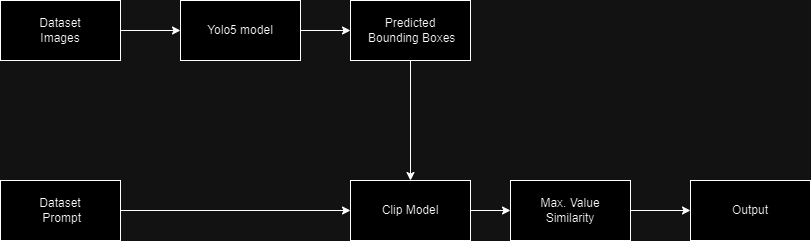

Building upon this baseline, we examine the results, challenges and issues & ventured into various avenues to refine and optimize our baseline with different approaches.

- **Training-Free Approaches with CLIP's Zero-Shot Learning**:
  Capitalizing on CLIP's zero-shot learning capabilities, we experimented with training-free strategies. The allure here is the power of CLIP to understand and map visual-textual relationships without the need for explicit fine-tuning on our target dataset.
  *   **Baseline with Padding:** Upon experimenting with simple pipeline, we noticed that while cropping images and resizing it loosing some information and it may cause poor results. Therefore we introduced padding.

  *   **Baseline with YOLO8:** Upon Some research and curisity we thought maybe because of speed and accuracy introduced with the recent model of yolo we might be able to get some fruitful results.
  
  *   **Baseline with DETR:** As YOLO is based on CNN models and with the recent advancement in Vision with the help of transformers we tried to test DETR model which is completely based on transformers. And also while doing some research on Visual Grounding tasks, we found lot of reserchers using DETR and also modifying it for visual grounding and image captioning.
  
  *   **Baseline + NLP (Subject Detection + ENR):** Upon Observation we noticed that the similarities of sentences and images were low very the context of object was present hence we tried to reduce the sentence into subject only with NLP techniques and in particular we used Spacy library then the subjects were compared with yolov5/8 predicted bboxes to see max similarity.

- **Fine-Tuning & Training Approaches**:
  While zero-shot learning offers a rapid deployment advantage, to push the boundaries of accuracy and precision, we also took the route of fine-tuning. This involved subtly adjusting the CLIP model, customizing it to better resonate with the nuances of the RefCOCOg dataset.
  *  **PROJECTION HEAD WITH BBOX REGRESSION LOSS:** As simplist approach we tried to test MLP projection head on concatenated features obtained from clip and passed through 4 linear layers followed by RELU activation. Due to limited resources we kept the batch size to 32 and epoch to 20.
  
  * **PROJECTION HEAD WITH BBOX REGRESSION AND IOU LOSS:** We also tried to test the model with two combined loses hoping they would perfrom better keeping the other parameters same.

- POSSIBLE METHODS NOT IMPLEMENTED
    * *Adding a Fusion Technique with transformers*

In subsequent sections, we'll dive deeper into the intricacies of each approach, shedding light on their respective behaviors, outcomes, and the challenges we encountered.

# How to Run this Notebook
To run this notebook, need to create the environment by downloading dataset, installing the required dependencies and setting up the directories following the cells given below.

First, need to download the dataset from the provided dataset link using the `gdown` library in 'dataset' directory,  unzip the downloaded dataset using the `tar` command. This process should take only 10 minutes on Colab.

#### Downloading Dataset

In [ ]:
!mkdir dataset
!cd dataset

In [ ]:
!pip install -qqq gdown
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq

In [ ]:
%%bash
tar -xvf /content/refcocog.tar.gz
rm /content/refcocog.tar.gz

### Installing & Importing Required Dependencies

In [ ]:
!pip install -U ultralytics
!pip install git+https://github.com/openai/CLIP.git
!pip install spacy
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm
!pip install tensorboard

In [ ]:
import os
import json
import pickle
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from clip import clip
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision.models import resnet50
from torchvision import transforms
import spacy

# Exploring & Understanding Datasets

The RefCOCOg dataset, which can be found [here](https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq), is tailored for the grounding referring expressions task. This dataset houses images, each accompanied by multiple sentences or phrases that describe certain objects within those images. These referring expressions and their corresponding objects are the focal points of visual grounding task. Here, we present an overview of the dataset, our approach to loading and preprocessing the data, and its significance in our project.

### Loading the Dataset

The dataset is structured into separate folders for images and annotations. The annotations include information about objects' bounding boxes, category IDs, segmentation details, and corresponding referring expressions.

In [ ]:
# Set the path to the dataset directory
dataset_dir = os.path.join(os.getcwd(), "dataset", "refcocog")
if not os.path.exists(dataset_dir):
    dataset_dir = os.path.join(os.getcwd(), "refcocog")

dataset_dir

'D:\\Study\\Trento University Study\\Samester-2\\Deep Learning\\Visual_Grounding_Project\\dataset\\refcocog'

In [ ]:
annotations_file = os.path.join(dataset_dir, 'annotations', 'instances.json')
refs_file = os.path.join(dataset_dir, "annotations", "refs(umd).p")
images_folder = os.path.join(dataset_dir, "images")

In [ ]:
with open(annotations_file, "r") as f:
    instances_ = json.load(f)

with open(refs_file, "rb") as f:
    refs_data = pickle.load(f)

In [ ]:
instances_.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [ ]:
instances_["images"][1]

{'license': 3,
 'file_name': 'COCO_train2014_000000524291.jpg',
 'coco_url': 'http://mscoco.org/images/524291',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-18 09:59:07',
 'flickr_url': 'http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg',
 'id': 524291}

In [ ]:
instances_["annotations"][0]

{'segmentation': [[21.11,
   239.09,
   16.31,
   274.6,
   198.65,
   349.45,
   240.87,
   336.98,
   320.52,
   293.79,
   334.91,
   248.69,
   357.95,
   273.64,
   353.15,
   289.0,
   398.25,
   267.88,
   437.6,
   251.57,
   412.65,
   228.54,
   240.87,
   210.31,
   219.76,
   141.21,
   113.24,
   153.69,
   63.34,
   156.57,
   26.87,
   169.04]],
 'area': 48667.84089999999,
 'iscrowd': 0,
 'image_id': 131074,
 'bbox': [16.31, 141.21, 421.29, 208.24],
 'category_id': 65,
 'id': 318235}

In [ ]:
instances_["categories"][0:5]

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]

In [ ]:
refs_data[0]

{'image_id': 380440,
 'split': 'test',
 'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'],
   'raw': 'the man in yellow coat',
   'sent_id': 8,
   'sent': 'the man in yellow coat'},
  {'tokens': ['skiier', 'in', 'red', 'pants'],
   'raw': 'Skiier in red pants.',
   'sent_id': 9,
   'sent': 'skiier in red pants'}],
 'file_name': 'COCO_train2014_000000380440_491042.jpg',
 'category_id': 1,
 'ann_id': 491042,
 'sent_ids': [8, 9],
 'ref_id': 0}

In [ ]:
# get all annotation data for the image_id=380440
sample_annotations = instances_["annotations"]
sample_annotations_df = pd.DataFrame(sample_annotations)
sample_annotations_df[sample_annotations_df["image_id"] == 380440]

segmentation         area  \
96094  [[362.48, 277.14, 332.06, 210.39, 335.44, 165....  15877.13600   
96095  [[386.14, 222.22, 397.97, 158.85, 436.84, 158....  10315.83825   
96096  [[348.53, 298.33, 385.28, 261.58, 384.97, 269....   1658.13485   
96097  [[304.34, 200.09, 291.38, 190.07, 293.74, 195....    614.97200   
96098  [[460.99, 102.16, 454.66, 99.0, 448.86, 97.68,...    471.07410   
96099  [[295.86, 95.78, 290.84, 103.6, 288.6, 100.25,...    142.09260   

       iscrowd  image_id                             bbox  category_id  \
96094        0    380440   [228.98, 41.4, 141.95, 270.38]            1   
96095        0    380440  [374.31, 65.06, 136.04, 201.94]            1   
96096        0    380440   [244.21, 251.3, 141.07, 90.63]           35   
96097        0    380440  [291.38, 190.07, 185.19, 68.27]           35   
96098        0    380440    [416.16, 95.57, 66.98, 58.28]           27   
96099        0    380440     [288.6, 75.67, 54.76, 27.93]           27   

            id  
96094   470048  
96095   491042  
96096   607150  
96097   608103  
96098  1417747  
96099  1421553

### Preprocessing and Dataset Class:

To facilitate easy access and manipulations, the data is loaded into Pandas DataFrames. We employ two major files: `instances.json` for bounding box annotations and `refs(umd).p` for referring expressions.

1. **Bounding Box Conversion**:
   A helper function, `convert_bbox`, is used to change the format of bounding boxes from `[x, y, w, h]` to `[x1, y1, x2, y2]`.

2. **RefCOCOg Dataset Class**:
   The `RefCOCOgDataset` class is the heart of our dataset processing. This class:
   - Loads the annotations and references.
   - Merges the two datasets based on the annotation ID.
   - Filters the data based on the desired split (train, validation, test).
   - Converts bounding box format as required.
   - Provides methods to access individual items and other relevant data.

In [ ]:
# method to convert bbox from [x, y, w, h] to [x1, y1, x2, y2]
def convert_bbox(bb):
    x, y, w, h = bb
    x1_cord, y1_cord = x, y
    x2_cord, y2_cord = x + w, y + h

    return [x1_cord, y1_cord, x2_cord, y2_cord]

In [ ]:
class RefCOCOgDataset(Dataset):
    def __init__(self, dataset_dir_, split='train', no_of_samples=None):
        self.dataset_dir = dataset_dir
        self.images_dir = os.path.join(dataset_dir_, "images")
        self.annotations_dir = os.path.join(dataset_dir_, "annotations")
        self.instances_path = os.path.join(self.annotations_dir, "instances.json")
        self.refs_path = os.path.join(self.annotations_dir, "refs(umd).p")

        with open(self.instances_path, "r") as file:
            self.instances_df = pd.DataFrame(json.load(file)["annotations"])
            self.instances_df = self.instances_df.reset_index(drop=True)

        with open(self.refs_path, "rb") as file:
            self.refs_df = pd.DataFrame(pickle.load(file))
            # explode the sentences column to get one row for each sentence
            # self.refs_df = self.refs_df.explode("sentences")
            self.refs_df = self.refs_df.reset_index(drop=True)

        # merge the instances and refs data frames based on the ann_id column and id column
        self.data = pd.merge(self.refs_df, self.instances_df, left_on="ann_id", right_on="id")
        self.data = self.data.explode(['sentences', 'sent_ids'])
        self.data = self.data.reset_index()
        self.data.drop(columns=['index'], inplace=True)
        self.data['sentences'] = self.data['sentences'].apply(lambda x: x['raw'])

        # filter out the data frame based on the split
        self.data = self.filter_df(split, drop_unnecessary_cols=True)

        # convert the bbox from [x, y, w, h] to [x1, y1, x2, y2]
        self.data['bbox'] = self.data['bbox'].apply(lambda x: convert_bbox(x))

        if no_of_samples:
            # get first n samples from the data frame
            self.data = self.data[:no_of_samples]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx]

    def filter_df(self, split, drop_unnecessary_cols=True):
        if drop_unnecessary_cols:
            drop_cols = ['category_id_x', 'ann_id', 'sent_ids', 'iscrowd', 'image_id_y',
                         'image_id_x', 'segmentation', 'id', 'category_id_y', 'ref_id', 'area']
            self.data = self.data.drop(columns=drop_cols)

        return self.data[self.data['split'] == split]

    def get_annotation_data(self, idx):
        return self.instances_df.iloc[idx]

    def get_image_data(self, idx):
        return self.refs_df.iloc[idx]

#### Create RefCOCOg Dataset Instance

To save the time and computation resuourses we divided dataset into three 15000 trainig, 4000 testing and 1500 evaulation subsets.

In [ ]:
# create an instance of the RefCOCOgDataset class for the train/val/test splits
refcocog_dataset_train = RefCOCOgDataset(dataset_dir, split='train', no_of_samples=15000)
refcocog_dataset_val = RefCOCOgDataset(dataset_dir, split='val', no_of_samples=1500)
refcocog_dataset_test = RefCOCOgDataset(dataset_dir, split='test', no_of_samples=4000)

In [ ]:
len(refcocog_dataset_train), len(refcocog_dataset_val), len(refcocog_dataset_test)

(15000, 1500, 4000)

In [ ]:
refcocog_dataset_test.data.head(10)

split                                          sentences  \
0  test                             the man in yellow coat   
1  test                               Skiier in red pants.   
2  test  There is red colored truck in between the othe...   
3  test                   A shiny red vintage pickup truck   
4  test                           A apple desktop computer   
5  test     the white IMac computer that is also turned on   
6  test            A girl wearing glasses and a pink shirt   
7  test  an Asian girl with a pink shirt eating at the ...   
8  test                                 WOMAN IN COVERALLS   
9  test                          a person wearing overalls   

                                file_name  \
0  COCO_train2014_000000380440_491042.jpg   
1  COCO_train2014_000000380440_491042.jpg   
2  COCO_train2014_000000419645_398406.jpg   
3  COCO_train2014_000000419645_398406.jpg   
4  COCO_train2014_000000478885_124383.jpg   
5  COCO_train2014_000000478885_124383.jpg   
6  COCO_train2014_000000323240_192943.jpg   
7  COCO_train2014_000000323240_192943.jpg   
8  COCO_train2014_000000041700_197196.jpg   
9  COCO_train2014_000000041700_197196.jpg   

                                         bbox  
0              [374.31, 65.06, 510.35, 267.0]  
1              [374.31, 65.06, 510.35, 267.0]  
2   [93.95, 83.29, 598.5600000000001, 373.86]  
3   [93.95, 83.29, 598.5600000000001, 373.86]  
4              [338.8, 82.19, 486.14, 239.56]  
5              [338.8, 82.19, 486.14, 239.56]  
6  [45.2, 166.76, 192.64999999999998, 346.49]  
7  [45.2, 166.76, 192.64999999999998, 346.49]  
8             [496.24, 82.81, 579.04, 251.52]  
9             [496.24, 82.81, 579.04, 251.52]

#### Create DataLoader Instances

In [ ]:
# collate function for the RefCOCOg dataset loader
def collate_fn(batch_):
    _, img_, query, bboxes = zip(*batch_)

    return img_, query, bboxes

In [ ]:
# create a DataLoader instance for the train/val/test splits
train_dataloader = DataLoader(refcocog_dataset_train, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
val_dataloader = DataLoader(refcocog_dataset_val, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
test_dataloader = DataLoader(refcocog_dataset_test, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)

In [ ]:
next(iter(train_dataloader))

[['Two woman one in black eatting and the other has a white shirt at the desk'],
 ['COCO_train2014_000000519404_1241542.jpg'],
 [[0.0, 45.95, 238.92, 454.59]]]

# Utility Functions/Classes

In [ ]:
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append

    return string

In [ ]:
def crop_image(image, bb):
    """
    Function to crop the image with the given bounding boxes and save them to the disk.
    :param image: PIL image object
    :param bb: list of bounding boxes [x, y, w, h] for the current image
    :return: cropped image
    """
    x1_cord, y1_cord, x2_cord, y2_cord = bb[0:4]

    cropped_image = image.crop((x1_cord, y1_cord, x2_cord, y2_cord))

    return cropped_image

In [ ]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    """
    Convert bounding box format from [cx, cy, w, h] to [x1, y1, x2, y2]
    :param x: bounding boxes in [cx, cy, w, h] format, with values ranging from 0 to 1
    :return: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to 1
    """
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]

    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    """
    Convert bounding box scales (tensor) to image scales
    :param out_bbox: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to 1
    :param size: PIL image size
    :return: bounding boxes in [x1, y1, x2, y2] format, with values ranging from 0 to image dimension
    """
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)  # [x1, y1, x2, y2] format
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)  # rescale to image scales
    return b

def detr_plot_results(pil_img, results_, query=None):
    """
    Show image results
    :param pil_img: PIL image
    :param results_: inference results
    :param query: query string
    """
    # colors for visualization
    colors = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
              [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for res, color in zip(results_, colors * 100):
        label = res['label']
        score = res['score']
        box = res['box']
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color=color, linewidth=3))
        text = f'{label}: {score}'
        ax.text(box[0], box[1], text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))

    if query is not None:
        # add title with query string
        plt.title(query, fontdict={'fontsize': 20})

    plt.axis('off')
    plt.show()

In [ ]:
def calculate_iou(predicted_bbox, gt_bbox_):
    """
    Function to calculate the intersection over union (IoU) between two bounding boxes
    :param predicted_bbox: list of predicted bounding boxes
    :param gt_bbox_: list of ground truth bounding boxes
    :return: list of IoU values
    """
    # Extract coordinates of each bounding box
    x1_coord, y1_coord, x2_coord, y2_coord = predicted_bbox
    x3_coord, y3_coord, x4_coord, y4_coord = gt_bbox_

    # Calculate coordinates of intersection rectangle
    x5_coord = max(x1_coord, x3_coord)
    y5_coord = max(y1_coord, y3_coord)
    x6_coord = min(x2_coord, x4_coord)
    y6_coord = min(y2_coord, y4_coord)

    # Calculate width and height of intersection rectangle
    width_ = max(0, x6_coord - x5_coord)
    height_ = max(0, y6_coord - y5_coord)

    # Calculate areas of bounding boxes and intersection rectangle
    predicted_bbox_area = (x2_coord - x1_coord) * (y2_coord - y1_coord)
    gt_bbox_area = (x4_coord - x3_coord) * (y4_coord - y3_coord)
    intersection_area = width_ * height_

    union_area = predicted_bbox_area + gt_bbox_area - intersection_area

    iou = intersection_area / union_area

    return iou

In [ ]:
class Recall:
    def __init__(self, tp=0, fn=0):
        self.tp = tp
        self.fn = fn

    def update(self, tp):
        if tp:  # if true positive then update tp
            self.tp += 1
        else:  # if false negative then update fn
            self.fn += 1

    def calculate(self):
        return self.tp / (self.tp + self.fn)

    def reset(self):
        self.tp = 0
        self.fn = 0

In [ ]:
class Metrics:
    def __init__(self, model, eval_desc, threshold=0.5, img_size=224):
        self.model = model
        self.eval_desc = eval_desc
        self.threshold = threshold
        self.img_size = img_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])

        self.recall = Recall()
        self.iou_list = []
        self.cosine_similarity_list = []
        self.euclidean_distance_list = []

    def update(self, predicted_bb, gt_bb, predicted_img, gt_img):
        with torch.no_grad():
            predicted_img_padded = pad_image(predicted_img)
            gt_img_padded = pad_image(gt_img)
            predicted_img_tensor = self.transform(predicted_img_padded).unsqueeze(0).cuda()
            gt_img_tensor = self.transform(gt_img_padded).unsqueeze(0).cuda()

            predicted_img_embedding = self.model.encode_image(predicted_img_tensor)
            gt_img_embedding = self.model.encode_image(gt_img_tensor)

        cosine_similarity_ = nn.functional.cosine_similarity(predicted_img_embedding, gt_img_embedding)
        euclidean_distance_ = nn.functional.pairwise_distance(predicted_img_embedding, gt_img_embedding)

        predicted_bb = predicted_bb[:4]
        gt_bb = gt_bb[:4]
        predicted_bb = torch.tensor(predicted_bb)
        gt_bb = torch.tensor(gt_bb)

        # iou_ = ops.box_iou(predicted_bb.unsqueeze(0), gt_bb.unsqueeze(0)).squeeze(0).squeeze(0)
        iou_ = calculate_iou(predicted_bb, gt_bb)
        self.iou_list.append(iou_)

        self.recall.update(iou_ > self.threshold)
        self.cosine_similarity_list.append(cosine_similarity_)
        self.euclidean_distance_list.append(euclidean_distance_)

    def calculate(self):
        iou_mean = torch.mean(torch.stack(self.iou_list))
        cosine_similarity_mean = torch.mean(torch.stack(self.cosine_similarity_list))
        euclidean_distance_mean = torch.mean(torch.stack(self.euclidean_distance_list))

        return self.recall.calculate(), iou_mean, cosine_similarity_mean, euclidean_distance_mean

    def __str__(self):
        return f"Recall: {self.recall.calculate():.4f}, IoU: {self.calculate()[1]:.4f}, Cosine Similarity: {self.calculate()[2]:.4f}, Euclidean Distance: {self.calculate()[3]:.4f}"

    def get_recall(self):
        return self.recall.calculate()

    def get_iou(self):
        return torch.mean(torch.stack(self.iou_list))

    def get_cosine_similarity(self):
        return torch.mean(torch.stack(self.cosine_similarity_list))

    def get_euclidean_distance(self):
        return torch.mean(torch.stack(self.euclidean_distance_list))

    def reset(self):
        self.recall.reset()
        self.iou_list = []
        self.cosine_similarity_list = []
        self.euclidean_distance_list = []

    def save(self):
        df_ = pd.DataFrame({
            "iou": [iou.cpu().item() for iou in self.iou_list],
            "cosine_similarity": [cosine_similarity.cpu().item() for cosine_similarity in self.cosine_similarity_list],
            "euclidean_distance": [euclidean_distance.cpu().item() for euclidean_distance in self.euclidean_distance_list]
        })

        df_.to_csv(self.eval_desc + "_iou.csv", index=False)

In [ ]:
def adjust_tensor_size(tensor, target_size):
    if tensor.shape[0] < target_size:
        padding_size = target_size - tensor.shape[0]
        padding = torch.zeros(padding_size, *tensor.shape[1:]).to(tensor.device)
        tensor = torch.cat([tensor, padding], dim=0)
    else:
        tensor = tensor[:target_size]
    return tensor

# Training Free Approaches

Looking at the results achived from the baseline we tried to further investigate the zero shot capabilities of clip with following methods:

## Visual Grounding Base Pipeline with YOLOv5/YOLOv8 and CLIP + Padding
The baseline harnesses the prowess of YOLO5 to discern potential objects in a given image. Following the extraction of bounding boxes, CLIP comes into play, establishing similarity scores between the textual label and the corresponding image segment. A pivotal element to note is the introduction of padding.

While experimenting with simple pipeline, the one we talked about earlier, we noticed an issue. While cropping images and resizing to 224x224 to make the image compatible for CLIP model, especially for small objects, image loses some information, and it may effect the results. To deal with this issue we introduced padding which ensures that the processed image is compatible with the CLIP model and preserves the content of the original image.

1. *Padding*: If the image dimensions are smaller than 224x224, the image will be padded with a color that matches the average color of the original image.
2. *Resize*: After padding (or directly if the image dimensions were initially greater than 224x224), the image is resized to precisely 224x224 pixels to fit the CLIP input size. Hence for each Baseline described below we used the padding crops for improved results.

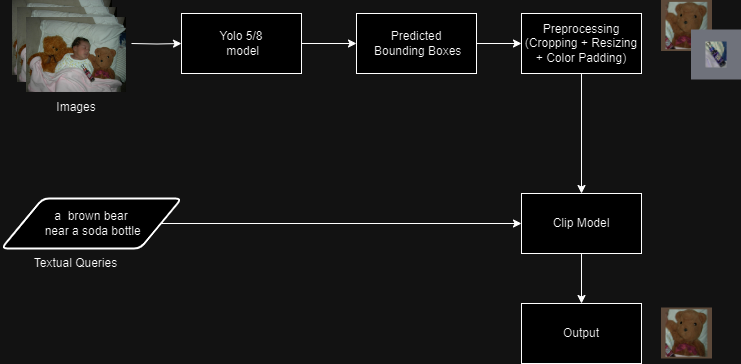

### Padding Function

In [ ]:
def pad_image(pil_img):
    """
    Preprocess the input image to fit CLIP's input size of 224x224 pixels.

    The function pads the image if its dimensions are smaller than 224x224,
    using the average color of the original image. Post padding, the image
    is resized to the exact required dimensions of 224x224 pixels.

    Parameters:
    ----------
    pil_img : PIL.Image
        The input image that needs to be processed.

    Returns:
    -------
    PIL.Image
        The processed image with dimensions 224x224 pixels.
    """
    # Calculate average color
    avg_color_per_row = np.average(pil_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    old_image_width, old_image_height = pil_img.size

    new_image_width = max(old_image_width, 224)
    new_image_height = max(old_image_height, 224)

    color = avg_color
    result = np.full((new_image_height, new_image_width, 3), color, dtype=np.uint8)

    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    result[y_center:y_center+old_image_height, x_center:x_center+old_image_width] = pil_img

    pil_img = Image.fromarray(result)
    pil_img = pil_img.resize((224, 224))
    return pil_img

### Baseline with Padding Class

In [ ]:
class YOLOCLIPVisualGroundingBaselineNN(nn.Module):
    def __init__(self, device="cuda", clip_model_variant='RN50', yolo_model_variant='yolov5s', model_desc="baseline", detection_threshold=0.7, iou_threshold=0.45):
        super(YOLOCLIPVisualGroundingBaselineNN, self).__init__()

        self.device = device
        self.yolo_model_variant = yolo_model_variant

        if yolo_model_variant == 'yolov5s':
            self.yolo_model = torch.hub.load('ultralytics/yolov5', yolo_model_variant, pretrained=True).to(device)
            self.yolo_model.conf = detection_threshold
            self.yolo_model.iou = iou_threshold
        elif yolo_model_variant == 'yolov8s':
            self.yolo_model = YOLO(yolo_model_variant).to(device)
        else:
            raise ValueError("Invalid YOLO model variant. Please choose from ['yolov5s', 'yolov8s']")

        self.clip_model, self.clip_preprocess = clip.load(clip_model_variant, device=device)

        self.metrics = Metrics(self.clip_model, eval_desc=model_desc)

    def forward(self, img_path, textual_query):
        image = Image.open(img_path).convert("RGB")
        if self.yolo_model_variant == 'yolov5s':
            yolo_detections = self.yolo_model(img_path)
            predicted_boxes = yolo_detections.xyxy[0].cpu().numpy().tolist()
        elif self.yolo_model_variant == 'yolov8s':
            yolo_detections = self.yolo_model(img_path)
            predicted_boxes = [box.xyxy[0].tolist() for box in yolo_detections[0].boxes]
        else:
            raise ValueError("Invalid YOLO model variant. Please choose from ['yolov5s', 'yolov8s']")

        text_tokens = clip.tokenize([textual_query]).to(self.device)
        with torch.no_grad():
            text_features_ = self.clip_model.encode_text(text_tokens).float()

        cropped_images_ = []
        for bb in predicted_boxes:
            cropped_images_.append(pad_image(crop_image(image, bb)))

        cropped_images_features = []
        for cropped_image in cropped_images_:
            cropped_image_tensor = self.clip_preprocess(cropped_image).cuda().unsqueeze(0)
            with torch.no_grad():
                cropped_image_features = self.clip_model.encode_image(cropped_image_tensor).float()
            cropped_image_features /= cropped_image_features.norm(dim=-1, keepdim=True)
            cropped_images_features.append(cropped_image_features)

        # Batch process cropped images
        try:
            cropped_images_tensor = torch.cat(cropped_images_features)  # concatenate along the batch dimension
            text_features_ = text_features_.cuda()
            text_features_ /= text_features_.norm(dim=-1, keepdim=True)  # normalize the text features tensor
        except RuntimeError:  # if the cropped images list is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        # Calculate similarities using NumPy operations
        text_features_np = text_features_.cpu().numpy()  # convert text features tensor to NumPy array
        cropped_images_features_np = cropped_images_tensor.cpu().numpy()  # convert cropped images features tensor to NumPy array
        similarities = np.matmul(text_features_np, cropped_images_features_np.T)  # matrix multiplication between text and image features
        try:
            max_similarity_idx = np.argmax(similarities)  # get the index of the highest similarity
        except ValueError:  # if the similarities array is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        return cropped_images_[max_similarity_idx], predicted_boxes[max_similarity_idx]

    def evaluate(self, image, textual_query, gt_bbox_):
        gt_img = Image.open(image).convert("RGB")
        gt_img_crop = pad_image(crop_image(gt_img, gt_bbox_))

        predicted_img, predicted_bbox = self.forward(image, textual_query)
        self.metrics.update(predicted_bbox, gt_bbox_, predicted_img, gt_img_crop)

        return predicted_img, predicted_bbox

    def get_results(self):
        return self.metrics.__str__()

## DETR (End-to-End Object Detection with Transformers)

As per some observations we noticed that YOLO model was failing to detect some objects that were referred in the prompts hence producing hinderance in results. Therefore, upon some research and in particular a paper called Dynamic MDETR from Fengyuan Shi et al we got inspiration to explore transformer based Object detection model for visual grounding task.
The model workflow in the approach is as follows:

1. DETR tries to detect all the possible objects in an image.
2. The proposed bounding boxes generated by DETR are then passed to the CLIP model.
3. The CLIP model calculates similarity scores between the cropped image obtained from each bounding box and the corresponding text label.
4. The cropped image, along with the associated coordinates of the bounding box, having the highest similarity score is selected as the output of the model.

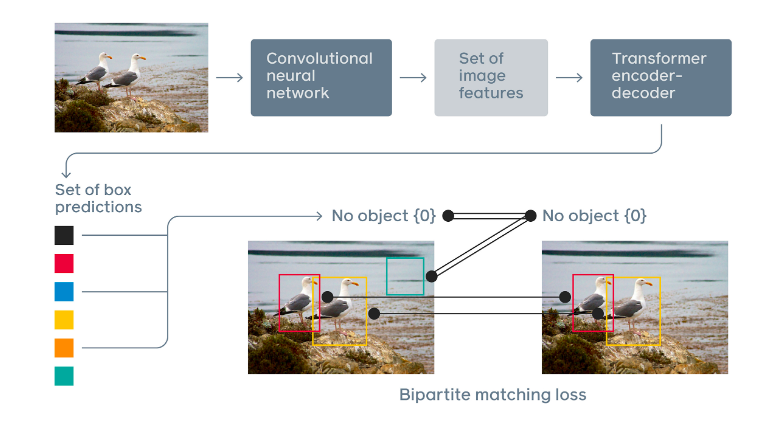


### DETRDetector Class

In [ ]:
class DETRDetector(nn.Module):
    """
    DETR implementation with the following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    Only batch size 1 supported.
    """
    def __init__(self, th=0.7, hidden_dim=256, n_heads=8, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        self.classes = [
            'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
            'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
            'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
            'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
            'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
            'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
            'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
            'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
            'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
            'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
            'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
            'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush'
        ]

        self.th = th

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(hidden_dim, n_heads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        self.linear_class = nn.Linear(hidden_dim, len(self.classes) + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs, img_size):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        height_, width_ = h.shape[-2:]
        try:
            pos = torch.cat([
                self.col_embed[:width_].unsqueeze(0).repeat(height_, 1, 1),
                self.row_embed[:height_].unsqueeze(1).repeat(1, width_, 1),
            ], dim=-1).flatten(0, 1).unsqueeze(1)
        except RuntimeError:
            # adjust positional encodings size
            col_embed_new = adjust_tensor_size(self.col_embed, width_)
            row_embed_new = adjust_tensor_size(self.row_embed, height_)

            # if col_embed or row_embed are nn.Parameter, ensure the adjusted tensors are as well
            if isinstance(self.col_embed, torch.nn.Parameter):
                col_embed_new = torch.nn.Parameter(col_embed_new)
            if isinstance(self.row_embed, torch.nn.Parameter):
                row_embed_new = torch.nn.Parameter(row_embed_new)

            # update positional encodings
            self.col_embed = col_embed_new
            self.row_embed = row_embed_new

            # construct positional encodings again with the adjusted positional encodings
            pos = torch.cat([
                self.col_embed[:width_].unsqueeze(0).repeat(height_, 1, 1),
                self.row_embed[:height_].unsqueeze(1).repeat(1, width_, 1),
            ], dim=-1).flatten(0, 1).unsqueeze(1)


        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        preds_logits = self.linear_class(h)
        probs = preds_logits.softmax(-1)[0, :, :-1]
        keep = probs.max(-1).values > self.th

        probs = probs[keep]
        boxes = self.linear_bbox(h).sigmoid()
        boxes = boxes[0, keep]

        bboxes = rescale_bboxes(boxes, img_size)

        results = []
        for prob, box in zip(probs, bboxes):
            results.append(
                {'label': self.classes[prob.argmax()], 'score': f'{prob[prob.argmax()]:0.2f}', 'box': box.tolist()}
            )
        return results

### Visual Grounding Base Pipeline with DETR and CLIP
1.   Here we are defining the baseline model class that is capable of encorporating any version of clip backbone and also different version of yolo.
2.   Clip is providing us with the encoding of text and image crops generated by yolo.
3.   workflow is same original baseline.

In [ ]:
class DETRCLIPVisualGroundingBaselineNN(nn.Module):
    def __init__(self, device="cuda", clip_model_variant='RN50', detector_th=0.5, model_desc="baseline"):
        super(DETRCLIPVisualGroundingBaselineNN, self).__init__()

        self.device = device

        self.detr_detector_model = DETRDetector(th=detector_th)
        state_dict = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
            map_location=self.device, check_hash=True)
        self.detr_detector_model.load_state_dict(state_dict)
        self.detr_detector_model.eval()

        self.detr_transform = transforms.Compose([
            transforms.Resize(800),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.clip_model, self.clip_preprocess = clip.load(clip_model_variant, device=device)

        self.metrics = Metrics(self.clip_model, eval_desc=model_desc)

    def forward(self, img_path, textual_query):
        image = Image.open(img_path).convert("RGB")

        img = self.detr_transform(image).unsqueeze(0)
        results = self.detr_detector_model(img, image.size)

        bboxes = [result['box'] for result in results]

        text_tokens = clip.tokenize([textual_query]).to(self.device)
        with torch.no_grad():
            text_features_ = self.clip_model.encode_text(text_tokens).float()

        cropped_images_ = []
        for bb in bboxes:
            cropped_images_.append(crop_image(image, bb))

        cropped_images_features = []
        for cropped_image in cropped_images_:
            cropped_image_tensor = self.clip_preprocess(cropped_image).cuda().unsqueeze(0)
            with torch.no_grad():
                cropped_image_features = self.clip_model.encode_image(cropped_image_tensor).float()
            cropped_image_features /= cropped_image_features.norm(dim=-1, keepdim=True)
            cropped_images_features.append(cropped_image_features)

        # Batch process cropped images
        try:
            cropped_images_tensor = torch.cat(cropped_images_features)  # concatenate along the batch dimension
            text_features_ = text_features_.cuda()
            text_features_ /= text_features_.norm(dim=-1, keepdim=True)  # normalize the text features tensor
        except RuntimeError:  # if the cropped images list is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        # Calculate similarities using NumPy operations
        text_features_np = text_features_.cpu().numpy()  # convert text features tensor to NumPy array
        cropped_images_features_np = cropped_images_tensor.cpu().numpy()  # convert cropped images features tensor to NumPy array
        similarities = np.matmul(text_features_np, cropped_images_features_np.T)  # matrix multiplication between text and image features
        try:
            max_similarity_idx = np.argmax(similarities)  # get the index of the highest similarity
        except ValueError:  # if the similarities array is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        return cropped_images_[max_similarity_idx], bboxes[max_similarity_idx]

    def evaluate(self, image, textual_query, gt_bbox_):
        gt_img = Image.open(image).convert("RGB")
        gt_img_crop = pad_image(crop_image(gt_img, gt_bbox_))

        predicted_img, predicted_bbox = self.forward(image, textual_query)
        self.metrics.update(predicted_bbox, gt_bbox_, predicted_img, gt_img_crop)

        return predicted_img, predicted_bbox

    def get_results(self):
        return self.metrics.__str__()

## Visual Grounding Base Pipeline with YOLOv5/YOLOv8 and CLIP + NLP

In this context, our approach involves utilizing the YOLO model, which is trained to recognize various object classes. We decided to enhance the process by first extracting the subject from the given prompt using natural language processing (NLP). Then, we specifically select the bounding box associated with the object class that has the highest similarity to the extracted subject. This approach optimizes the use of both visual and textual information to achieve accurate results. we have used spacy library for extracting the subject of the sentence.

workflow of the image can be seen below.


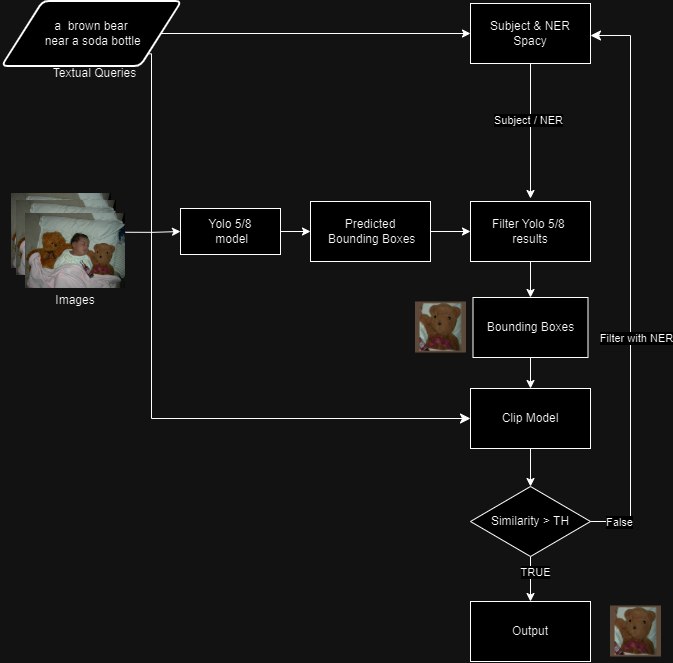

### Baseline with NLP (Subject and Entities)

In [ ]:
# Preprocessing function
def remove_of(sent):
    """
    Removes any "of" phrases from the sentence to improve entity extraction
    :param sent: The sentence to remove "of" phrases from
    :return: The sentence with "of" phrases removed
    """
    # Remove any "of" phrases from the sentence to improve entity extraction
    of_phrases = [
        "the side of", "the handle of", "the bunch of", "the corner of",
        "the top of", "the bottom of", "the front of", "the back of",
        "the edge of", "the middle of", "the end of", "the tip of",
        "the base of", "the center of", "the surface of", "the middle of",
        "the left of", "the right of", "the rear of", "the rim of"
    ]

    for phrase in of_phrases:
        if phrase in sent:
            index = sent.find(phrase)
            sent = sent[index + len(phrase):]
            return sent.strip()  # Stripping any leading or trailing whitespace
    return sent

In [ ]:
class YOLOCLIPNLPVisualGroundingBaselineNN(nn.Module):
    def __init__(self, device="cuda", clip_model_variant='RN50', yolo_model_variant='yolov5s', model_desc="baseline",
                 detection_threshold=0.7, iou_threshold=0.45, clip_th=0.12):
        super(YOLOCLIPNLPVisualGroundingBaselineNN, self).__init__()

        self.device = device
        self.yolo_model_variant = yolo_model_variant
        self.clip_th = clip_th
        self.detection_threshold = detection_threshold
        self.iou_threshold = iou_threshold

        if yolo_model_variant == 'yolov5s':
            self.yolo_model = torch.hub.load('ultralytics/yolov5', yolo_model_variant, pretrained=True).to(device)
            self.yolo_model.conf = detection_threshold
            self.yolo_model.iou = iou_threshold
            self.CLASSES = self.yolo_model.names
        elif yolo_model_variant == 'yolov8s':
            self.yolo_model = YOLO(yolo_model_variant).to(device)
            self.CLASSES = self.yolo_model.names
        else:
            raise ValueError("Invalid YOLO model variant. Please choose from ['yolov5s', 'yolov8s']")

        self.clip_model, self.clip_preprocess = clip.load(clip_model_variant, device=device)

        self.nlp = spacy.load("en_core_web_sm")

        self.metrics = Metrics(self.clip_model, eval_desc=model_desc)

    def get_embedding_for_text(self, text):
        """
        get embeddings for text
        :param text: str
        :return: torch.tensor
        """
        tokens = clip.tokenize([text]).to(self.device)
        with torch.no_grad():
            text_features = self.clip_model.encode_text(tokens).float()
            text_features /= text_features.norm(dim=-1, keepdim=True)

        return text_features

    def compute_similarity(self, text1, text2):
        """
        compute similarity between two texts
        :param text1: str
        :param text2: str
        :return: float
        """
        text1_embedding = self.get_embedding_for_text(text1)
        text2_embedding = self.get_embedding_for_text(text2)

        similarity = (text1_embedding @ text2_embedding.T).squeeze().item()
        return similarity

    def filter_detector_predictions(self, detector_results, subject_enr):
        """
        Filters the detector results by the subject/entities
        :param detector_results: bbox, classes, scores
        :param subject_enr: list of subjects or entities to filter the yolo detections by calculating similarity (text-to-text)
        :return: filtered results (bbox, classes, scores)
        """
        predictions_with_sim_scores = list()
        for bb, cls, score in zip(*detector_results):
            # calculate the similarity between the subject and each class or entity
            for enr in subject_enr:
                sim_score = self.compute_similarity(enr, "this is a " + cls)
                predictions_with_sim_scores.append((bb, cls, score, sim_score))

        # sort the predictions by the similarity score
        predictions_with_sim_scores.sort(key=lambda x: x[-1], reverse=True)

        return predictions_with_sim_scores[0]

    def get_root_or_subject(self, sent):
        """
        Extracts the root or subject of a sentence
        :param sent: The sentence to extract the root or subject from
        :return: The root or subject of the sentence
        """
        sent = sent.lower()

        starting_phrases = [
            "there is", "this is", "there are", "these are", "it is", "there's", "there're", "it's", "this's"
        ]

        # Remove the starting phrase from the sentence if it exists
        for phrase in starting_phrases:
            if sent.startswith(phrase):
                sent = sent[len(phrase):]
                break

        article_phrases = ["a ", "an ", "the "]

        # Remove any articles from the sentence to improve entity extraction
        for phrase in article_phrases:
            if sent.startswith(phrase):
                sent = sent[len(phrase):]
                break

        # Remove any "of" phrases from the sentence to improve entity extraction
        sent = remove_of(sent)

        # Extract the root or subject of the sentence
        doc = self.nlp(sent)
        for token in doc:
            # Check for nominal subjects
            if token.dep_ in ["nsubj", "nsubjpass"]:
                return token.text

        # If no nominal subject, return the root of the sentence
        return [token.text for token in doc if token.dep_ == "ROOT"]

    def extract_entities(self, sent):
        """
        Extracts the entities from a sentence
        :param sent: str
        :return: list
        """
        doc = self.nlp(sent)
        entities = [ent.text for ent in doc.ents] + [noun_chunk.text for noun_chunk in doc.noun_chunks]
        return entities

    def forward(self, img_path, textual_query):
        image = Image.open(img_path).convert("RGB")
        if self.yolo_model_variant == 'yolov5s':
            yolo_detections = self.yolo_model(img_path)
            pred_boxes = yolo_detections.xyxy[0].cpu().numpy().tolist()
            predicted_classes = [self.CLASSES[boxes[-1]] for boxes in pred_boxes]
            predicted_scores = [boxes[-2] for boxes in pred_boxes]
        elif self.yolo_model_variant == 'yolov8s':
            yolo_detections = self.yolo_model(img_path, conf=self.detection_threshold, iou=self.iou_threshold)
            pred_boxes = [box.xyxy[0].tolist() for box in yolo_detections[0].boxes]
            predicted_classes = [self.CLASSES[int(c)] for c in yolo_detections[0].boxes.cls]
            predicted_scores = yolo_detections[0].boxes.conf.tolist()
        else:
            raise ValueError("Invalid YOLO model variant. Please choose from ['yolov5s', 'yolov8s']")

        predicted_boxes = pred_boxes
        if len(predicted_boxes) == 0:
            return image, [0, 0, image.size[0], image.size[1]]  # return the original image and the whole image as the bounding box

        # apply filter on textual query -> detect subject/entities
        subject = self.get_root_or_subject(textual_query)
        # print("Subject: ", subject)

        # filter yolo detections by subject/entities
        predicted_boxes = self.filter_detector_predictions(
            detector_results=(predicted_boxes, predicted_classes, predicted_scores),
            subject_enr=subject)[0]

        text_tokens = clip.tokenize([textual_query]).to(self.device)
        with torch.no_grad():
            text_features_ = self.clip_model.encode_text(text_tokens).float()

        cropped_image = pad_image(crop_image(image, predicted_boxes))

        cropped_image_tensor = self.clip_preprocess(cropped_image).cuda().unsqueeze(0)
        with torch.no_grad():
            cropped_image_features = self.clip_model.encode_image(cropped_image_tensor).float()
        cropped_image_features /= cropped_image_features.norm(dim=-1, keepdim=True)

        # Batch process cropped images
        try:
            cropped_image_tensor = torch.cat([cropped_image_features])  # concatenate along the batch dimension
            text_features_ = text_features_.cuda()
            text_features_ /= text_features_.norm(dim=-1, keepdim=True)  # normalize the text features tensor
        except RuntimeError:  # if the cropped images list is empty
            return image, [0, 0, image.size[0], image.size[1]]  # return the org image and the whole image as the bbox

        # Calculate similarities using NumPy operations
        text_features_np = text_features_.cpu().numpy()  # convert text features tensor to NumPy array
        cropped_images_features_np = cropped_image_tensor.cpu().numpy()  # cropped img features tensor to NumPy array
        similarity = np.matmul(text_features_np, cropped_images_features_np.T)  # matrix multi between text and image features

        if similarity > self.clip_th:
            return cropped_image, predicted_boxes
        else:
            # if the similarity is less than the threshold, try to extract entities from the sentence and filter the yolo detections by entities
            entities = self.extract_entities(textual_query)

            # filter yolo detections by entities
            predicted_boxes = self.filter_detector_predictions(
                detector_results=(pred_boxes, predicted_classes, predicted_scores),
                subject_enr=entities)[0]

            cropped_image = pad_image(crop_image(image, predicted_boxes))

            cropped_image_tensor = self.clip_preprocess(cropped_image).cuda().unsqueeze(0)
            with torch.no_grad():
                cropped_image_features = self.clip_model.encode_image(cropped_image_tensor).float()
            cropped_image_features /= cropped_image_features.norm(dim=-1, keepdim=True)

            # Batch process cropped images
            try:
                cropped_image_tensor = torch.cat([cropped_image_features])  # concatenate along the batch dimension
                text_features_ = text_features_.cuda()
                text_features_ /= text_features_.norm(dim=-1, keepdim=True)  # normalize the text features tensor
            except RuntimeError:  # if the cropped images list is empty
                return image, [0, 0, image.size[0], image.size[1]]  # return the org image and the whole image as the bbox

            # Calculate similarities using NumPy operations
            text_features_np = text_features_.cpu().numpy()  # convert text features tensor to NumPy array
            cropped_images_features_np = cropped_image_tensor.cpu().numpy()  # cropped img features tensor to NumPy array
            similarity = np.matmul(text_features_np, cropped_images_features_np.T)  # matrix multi between text and image features

            if similarity > self.clip_th:
                return cropped_image, predicted_boxes
            else:
                return image, [0, 0, image.size[0], image.size[1]]  # return the org image and the whole image as the bbox

    def evaluate(self, image, textual_query, gt_bbox_):
        gt_img = Image.open(image).convert("RGB")
        gt_img_crop = pad_image(crop_image(gt_img, gt_bbox_))

        predicted_img, predicted_bbox = self.forward(image, textual_query)
        self.metrics.update(predicted_bbox, gt_bbox_, predicted_img, gt_img_crop)

        return predicted_img, predicted_bbox

    def get_results(self):
        return self.metrics.__str__()

## Evaluation

### Inference on Single Sample

#### YoloV5/V8 + CLIP + Padding

In [ ]:
baseline_model_yolo_clip = YOLOCLIPVisualGroundingBaselineNN(model_desc="Baseline_RN50_yolov5s_train")  # Default model is RN50
# baseline_model_yolo_clip = YOLOCLIPVisualGroundingBaselineNN(clip_model_variant='ViT-B/32', model_desc="Baseline_ViT-B32_yolov5s_train")

Using cache found in C:\Users\adnan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-8-20 Python-3.9.16 torch-2.1.0.dev20230609+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


D:\Study\Trento University Study\Samester-2\Deep Learning\Visual_Grounding_Project\dataset\refcocog\images\COCO_train2014_000000374391.jpg
Predicted Bounding Box: [348.9093933105469, 301.9761962890625, 443.2050476074219, 418.247802734375]
Ground Truth Bounding Box: [392.41, 187.79, 577.08, 400.92999999999995]
Sentence: a brown bear near a soda bottle


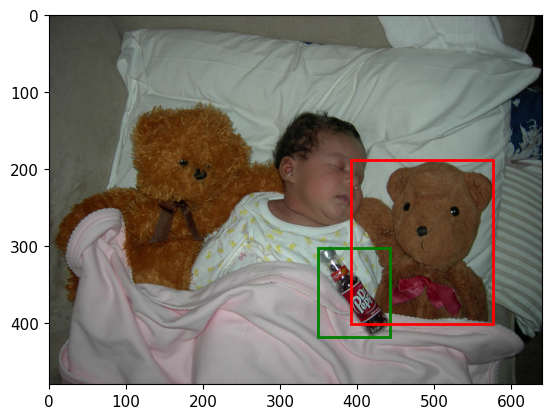

Recall: 0.0000, IoU: 0.1110, Cosine Similarity: 0.6855, Euclidean Distance: 1.6553


In [ ]:
baseline_model_yolo_clip.metrics.reset()
sample_input = refcocog_dataset_test[20]

image_path = os.path.join(images_folder, split_string(sample_input["file_name"]))
print(image_path)
sentence = sample_input["sentences"]
original_img = Image.open(image_path).convert("RGB")
gt = sample_input["bbox"]
x1, y1, x2, y2 = gt

crop = original_img.crop((x1, y1, x2, y2))
%matplotlib inline
plt.imshow(original_img)

img, bbox = baseline_model_yolo_clip.evaluate(image_path, sentence, gt)

# draw the predicted bounding box on the image (in green)
x1_, y1_, x2_, y2_ = bbox[0:4]
plt.gca().add_patch(plt.Rectangle((x1_, y1_), x2_-x1_, y2_-y1_, fill=False, edgecolor='green', linewidth=2))

# draw the ground truth bounding box on the image (in red)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))

print("Predicted Bounding Box:", bbox[0:4])
print("Ground Truth Bounding Box:", gt)
print("Sentence:", sentence)

# show the image
plt.show()

print(baseline_model_yolo_clip.get_results())

#### DETR + CLIP

In [ ]:
baseline_model_detr_clip = DETRCLIPVisualGroundingBaselineNN(model_desc="Baseline_ViT-B32_detr_train")  # Default model is RN50
# baseline_model_detr_clip = DETRCLIPVisualGroundingBaselineNN(clip_model_variant='ViT-B/32', model_desc="Baseline_ViT-B32_detr_train")

D:\Study\Trento University Study\Samester-2\Deep Learning\Visual_Grounding_Project\dataset\refcocog\images\COCO_train2014_000000374391.jpg
Predicted Bounding Box: [171.61846923828125, 125.66008758544922, 605.3941040039062, 475.595458984375]
Ground Truth Bounding Box: [392.41, 187.79, 577.08, 400.92999999999995]
Sentence: a brown bear near a soda bottle


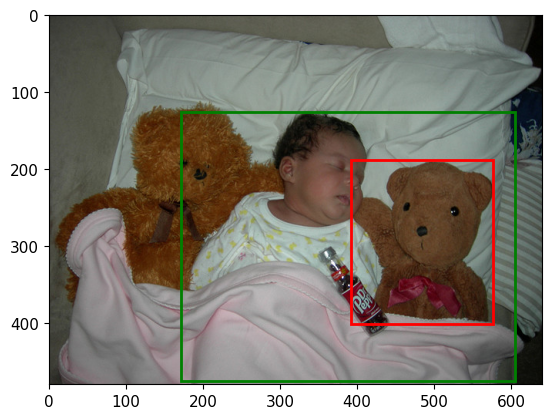

Recall: 0.0000, IoU: 0.2593, Cosine Similarity: 0.6655, Euclidean Distance: 2.0176


In [ ]:
baseline_model_detr_clip.metrics.reset()
sample_input = refcocog_dataset_test[20]

image_path = os.path.join(images_folder, split_string(sample_input["file_name"]))
print(image_path)
sentence = sample_input["sentences"]
original_img = Image.open(image_path).convert("RGB")
gt = sample_input["bbox"]
x1, y1, x2, y2 = gt

%matplotlib inline
plt.imshow(original_img)

# predict the bounding box for the given image and sentence
img, bbox = baseline_model_detr_clip.evaluate(image_path, sentence, gt)

# draw the predicted bounding box on the image (in green)
x1_, y1_, x2_, y2_ = bbox[0:4]
plt.gca().add_patch(plt.Rectangle((x1_, y1_), x2_-x1_, y2_-y1_, fill=False, edgecolor='green', linewidth=2))

# draw the ground truth bounding box on the image (in red)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))

print("Predicted Bounding Box:", bbox[0:4])
print("Ground Truth Bounding Box:", gt)
print("Sentence:", sentence)

# show the image
plt.show()

print(baseline_model_detr_clip.get_results())

#### YOLOv5/YOLOv8 and CLIP + NLP

In [ ]:
baseline_model_yolo_clip_nlp = YOLOCLIPNLPVisualGroundingBaselineNN(model_desc="Baseline_RN50_yolov5s_train")  # Default model is RN50
# baseline_model_yolo_clip_nlp = YOLOCLIPNLPVisualGroundingBaselineNN(clip_model_variant='ViT-B/32', model_desc="Baseline_ViT-B32_yolov5s_train")

Using cache found in C:\Users\adnan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-8-20 Python-3.9.16 torch-2.1.0.dev20230609+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


D:\Study\Trento University Study\Samester-2\Deep Learning\Visual_Grounding_Project\dataset\refcocog\images\COCO_train2014_000000374391.jpg
Predicted Bounding Box: [396.26519775390625, 191.4452362060547, 578.55126953125, 398.91943359375]
Ground Truth Bounding Box: [392.41, 187.79, 577.08, 400.92999999999995]
Sentence: a brown bear near a soda bottle


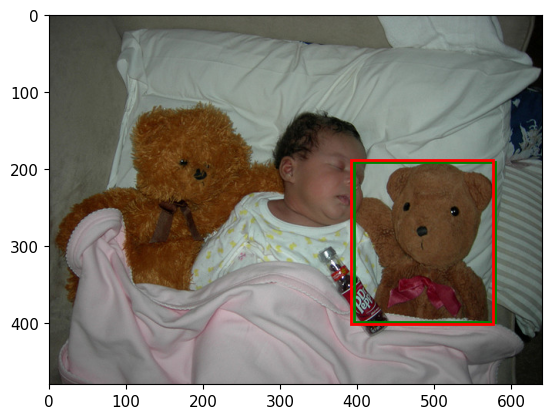

Recall: 1.0000, IoU: 0.9458, Cosine Similarity: 0.9790, Euclidean Distance: 0.4871


In [ ]:
baseline_model_yolo_clip_nlp.metrics.reset()
sample_input = refcocog_dataset_test[20]  #20

image_path = os.path.join(images_folder, split_string(sample_input["file_name"]))
print(image_path)
sentence = sample_input["sentences"]
original_img = Image.open(image_path).convert("RGB")
gt = sample_input["bbox"]
x1, y1, x2, y2 = gt

%matplotlib inline
plt.imshow(original_img)

# predict the bounding box for the given image and sentence
_, bbox = baseline_model_yolo_clip_nlp.evaluate(image_path, sentence, gt)

# draw the predicted bounding box on the image (in green)
x1_, y1_, x2_, y2_ = bbox[0:4]
plt.gca().add_patch(plt.Rectangle((x1_, y1_), x2_-x1_, y2_-y1_, fill=False, edgecolor='green', linewidth=2))

# draw the ground truth bounding box on the image (in red)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))

print("Predicted Bounding Box:", bbox[0:4])
print("Ground Truth Bounding Box:", gt)
print("Sentence:", sentence)

# show the image
plt.show()

print(baseline_model_yolo_clip_nlp.get_results())

### Evaluation baselines on Batch Dataset

#### Evaluate the baseline: YOLOv5/YOLOv8 and CLIP on the Dataloader

In [ ]:
baseline_model_yolo_clip.metrics.reset()
# evaluate the model on the dataloader
for i, batch in enumerate(tqdm(train_dataloader)):
    sentences_, images_, bboxes_ = batch
    for sentence_, image_, bbox_ in zip(sentences_, images_, bboxes_):
        image_path = os.path.join(images_folder, split_string(image_))
        original_img = Image.open(image_path).convert("RGB")
        baseline_model_yolo_clip.evaluate(image_path, sentence_, bbox_)

print(baseline_model_yolo_clip.get_results())

# save the metrics to the csv file
baseline_model_yolo_clip.metrics.save()

#### Evaluate the baseline: DETR and CLIP on the Dataloader

In [ ]:
baseline_model_detr_clip.metrics.reset()
# evaluate the model on the dataloader
for i, batch in enumerate(tqdm(train_dataloader)):
    sentences_, images_, bboxes_ = batch
    for sentence_, image_, bbox_ in zip(sentences_, images_, bboxes_):
        image_path = os.path.join(images_folder, split_string(image_))
        original_img = Image.open(image_path).convert("RGB")
        baseline_model_detr_clip.evaluate(image_path, sentence_, bbox_)

print(baseline_model_detr_clip.get_results())

# save the metrics to the csv file
baseline_model_detr_clip.metrics.save()

# FINE TUNING AND TRAINING

## Projection Head on Top of Clip


 **To keep it simple we thought of simple projection head on top of the Clip.
The features obtained by clip visual and textual encoders are concatenated and then passed through four Linear linear layers followed by relu activation functions. We trained the model for 30 epochs with Adam optimizer and MSE error loss.**




### Definition of the model

In [ ]:
import torch
import torch.nn as nn
import clip
import torch.nn.functional as F

class FusedProjectionModel(nn.Module):
    def __init__(self, device, clip_out_features, clip_model_variant='ViT-B/32'):
        super().__init__()

        self.device = device

        self.clip_model, self.clip_preprocess = clip.load(clip_model_variant, device=self.device)

        self.clip_out_features = clip_out_features

        self.regression_head = nn.Sequential(nn.Linear(2 * self.clip_out_features, self.clip_out_features),
                                            nn.ReLU(),
                                            nn.Linear(self.clip_out_features, self.clip_out_features // 2),
                                            nn.ReLU(),
                                            nn.Linear(self.clip_out_features // 2, 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 4)).to(self.device)

        print(self.regression_head[0].weight.dtype)
    def forward(self,images, prompts) -> torch.Tensor:

      preprocessed_images = torch.stack([
          self.clip_preprocess(image) for image in images
      ]).to(self.device)
      preprocessed_prompts = torch.cat([
          tokenized for tokenized in
          [clip.tokenize(prompt_list) for prompt_list in prompts]
      ]).to(self.device)

      with torch.no_grad():
          images_features = self.clip_model.encode_image(preprocessed_images).to(torch.float32)
          texts_features = self.clip_model.encode_text(preprocessed_prompts).to(torch.float32)


      # Feed each pair (image, prompt) pair to the FFNN and get
      # predictions in output
      bboxes=[]
      for image_feature,text_feature in zip(images_features,texts_features):
        x = torch.cat([image_feature, text_feature], dim=0)
        bbox = self.regression_head(x)
        bboxes.append(bbox)

      return torch.stack(bboxes)

### Defining Optimizer function

In [ ]:
# Optimizer
# Using an Adam optimizer

def get_optimizer(model, lr, wd=None, momentum=None):
    try:
        actual_model = model.regression_head
    except AttributeError:
        actual_model = model

    optimizer = torch.optim.Adam(actual_model.parameters(), lr=lr)

    return optimizer


### Cost Function

In [ ]:
def get_cost_function_FusedProjectionModel():
    cost_function = torch.nn.MSELoss()

    return cost_function

### Training_step and Testing_step

In [ ]:
# Defining both training and testing steps


def training_step(net, data_loader, optimizer, cost_function, device):

    samples = 0.0
    cumulative_loss = 0.0
    cumulative_iou = 0.0

    # Set the network to training mode
    net.train()
    optimizer.zero_grad()

    # Iterate over the training set
    for batch_idx, (prompt,filenames,gt) in enumerate(data_loader):
        # print(f'-- Batch index: {batch_idx} --')
        image_path = [os.path.join(images_folder, split_string(input)) for input in filenames]
        #x1, y1, x2, y2 = gt
        images = [Image.open(img).convert('RGB') for img in image_path]
        # Forward pass
        outputs = net(images, prompt)

        # Ground truth
        gt_bounding_boxes = torch.tensor(gt).to(device)

        # Loss computation
        loss = cost_function(outputs, gt_bounding_boxes)

        # Backward pass
        loss.backward()

        # Parameters update
        optimizer.step()

        # Gradients reset
        optimizer.zero_grad()

        # Update statistics
        samples += float(outputs.shape[0])
        cumulative_loss += float(loss.item())

        # Compute IoU
        for output_bbox, gt_bbox in zip(outputs, gt_bounding_boxes):
          output_bbox = [i.item() for i in output_bbox.squeeze(0)]
          cumulative_iou += calculate_iou(output_bbox, gt_bbox)

        if batch_idx % 100 == 0:
          print(f'at batch: {batch_idx} the cumulative_loss: {cumulative_loss/samples} ,iou_loss: {cumulative_iou/samples}')


    return cumulative_loss / samples, cumulative_iou / samples

def test_step(net , data_loader , cost_function , device='cuda'):

    samples = 0.0
    cumulative_loss = 0.0
    cumulative_iou = 0.0

    # set the network to evaluation mode
    net.eval()

    # Disable gradient computation (only testing!)
    with torch.no_grad():
        # Iterate over the test set
        for batch_idx, (prompt,filenames,gt) in enumerate(data_loader):
            # print(f'-- Batch index: {batch_idx} --')
            filenames = [split_string(filename) for filename in filenames]
            image_path = [os.path.join(images_folder,input) for input in filenames]
            images = [Image.open(im_path).convert('RGB') for im_path in image_path]
            # Forward pas
            outputs = net(images,prompt)

            # Ground truth
            gt_bounding_boxes = torch.tensor(gt).to(device)

            # Loss computation
            loss = cost_function(outputs, gt_bounding_boxes)

            # Update statistics
            samples += float(outputs.shape[0])
            cumulative_loss += float(loss.item())

            # Compute IoU
            for output_bbox, gt_bbox in zip(outputs, gt_bounding_boxes):
              output_bbox = [i.item() for i in output_bbox.squeeze(0)]
              cumulative_iou += calculate_iou(output_bbox, gt_bbox)

    return cumulative_loss / samples, cumulative_iou / samples

### Defining training function and after training test function

In [ ]:
from torch.utils.tensorboard import SummaryWriter

def log_values(writer, step, loss, accuracy, prefix):
    writer.add_scalar(f'{prefix}/loss', loss, step)
    writer.add_scalar(f'{prefix}/accuracy', accuracy, step)

def aftertraining_tests(net, train_loader, val_loader, test_loader, cost_function, device, writer=None, epochs=None):
    # Compute final evaluation results
    print('After training:')
    train_loss, train_accuracy = test_step(net, train_loader, cost_function, device=device)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function, device=device)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function, device=device)

    if writer is not None and epochs is not None:
        # Log to TensorBoard
        log_values(writer, epochs, train_loss, train_accuracy, "train")
        log_values(writer, epochs, val_loss, val_accuracy, "validation")
        log_values(writer, epochs, test_loss, test_accuracy, "test")

    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

def train(model,train_loader, val_loader, test_loader,cost_function,device='cuda:0',learning_rate=0.01,weight_decay=0.000001,
    momentum=0.9,
    epochs=10,
    skip_initial_train_test=False,
    skip_initial_val_test=False,
    skip_initial_test_test=False,
    ):

    # Create a logger
    writer = SummaryWriter(log_dir="runs/exp1")

    # Store the network
    net = model

    # Instantiate the optimizer
    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

    # Evaluate before training and log to TensorBoard
    print('Before training:')
    if skip_initial_train_test:
        train_loss, train_accuracy = test_step(net, test_dataloader, cost_function, device=device)
        log_values(writer, -1, train_loss, train_accuracy, "train")
        print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))

    if skip_initial_val_test:
        print('cc')
        val_loss, val_accuracy = test_step(net, val_loader, cost_function, device=device)
        log_values(writer, -1, val_loss, val_accuracy, "validation")
        print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))

    if skip_initial_test_test:
        test_loss, test_accuracy = test_step(net, test_loader, cost_function, device=device)
        log_values(writer, -1, test_loss, test_accuracy, "test")
        print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))

    print('-----------------------------------------------------')

    print('\n-- Starting training --')

    # Train for `epochs` steps
    for e in range(epochs):
        train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function, device=device)
        val_loss, val_accuracy = test_step(net, val_loader, cost_function, device=device)

        # Log to TensorBoard
        log_values(writer, e, train_loss, train_accuracy, "train")
        log_values(writer, e, val_loss, val_accuracy, "validation")

        print('Epoch: {:d}'.format(e+1))
        print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
        print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
        print('-----------------------------------------------------')

    aftertraining_tests(net, train_loader, val_loader, test_loader, cost_function, device, writer, epochs)

    # closes the logger
    writer.close()

### Starting Training

In [ ]:
# Define the cost function
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
cost_function = get_cost_function_FusedProjectionModel()
fusedProjectionModel = FusedProjectionModel('cuda',512)

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
# And train
train(fusedProjectionModel, train_dataloader, val_dataloader,test_dataloader,cost_function, epochs=5, device=device)

torch.float32


# Overlall RESULTS

## Result on Baseline


* Below we have listed all the tests performed as Baseline. We tried to experiment with yolo5 as well  as yolo8 in combination with different backbones provided by Clip model.
*   We concluded that results in combination with ViTB-32 & RN50 as clip backbone and YoloV5/V8 performed better in terms of all evaluation matrices.

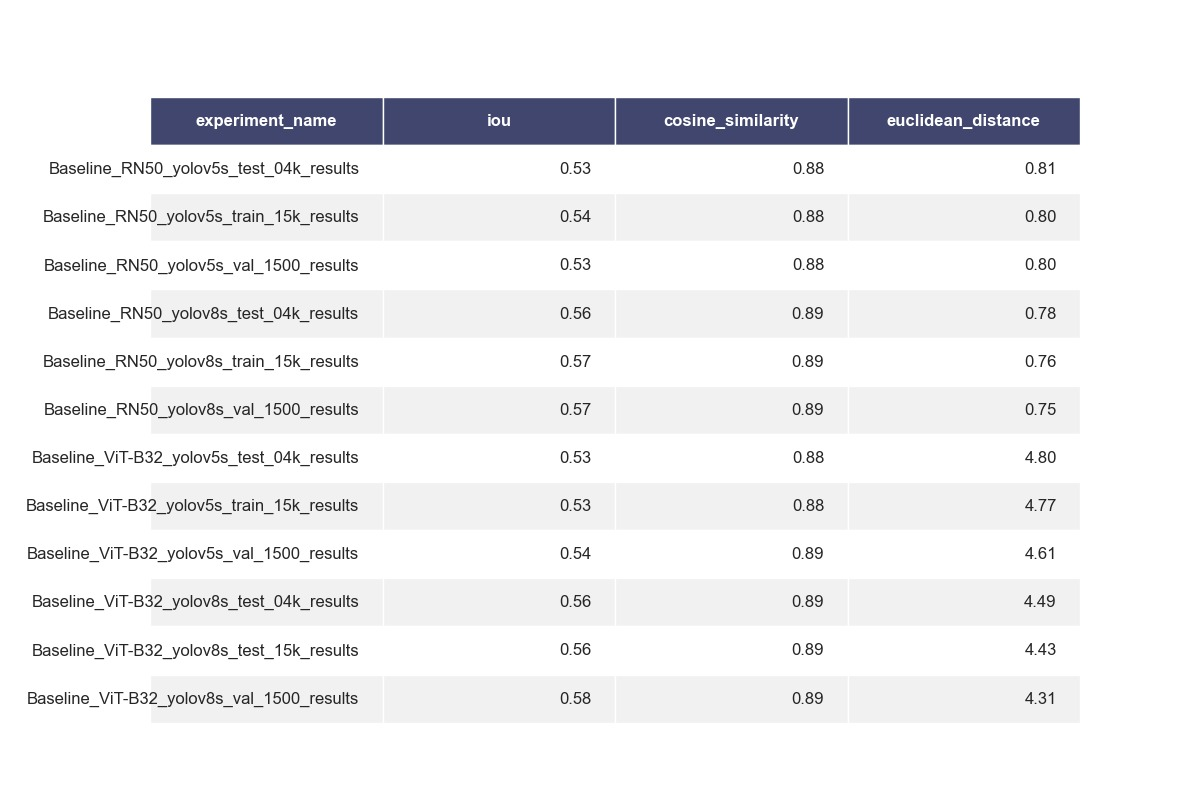

## BaseLine with DETR and ClIP



*   Based on the advancement in vision transformers we tried to see if using transfomer based Object detector could improve the results
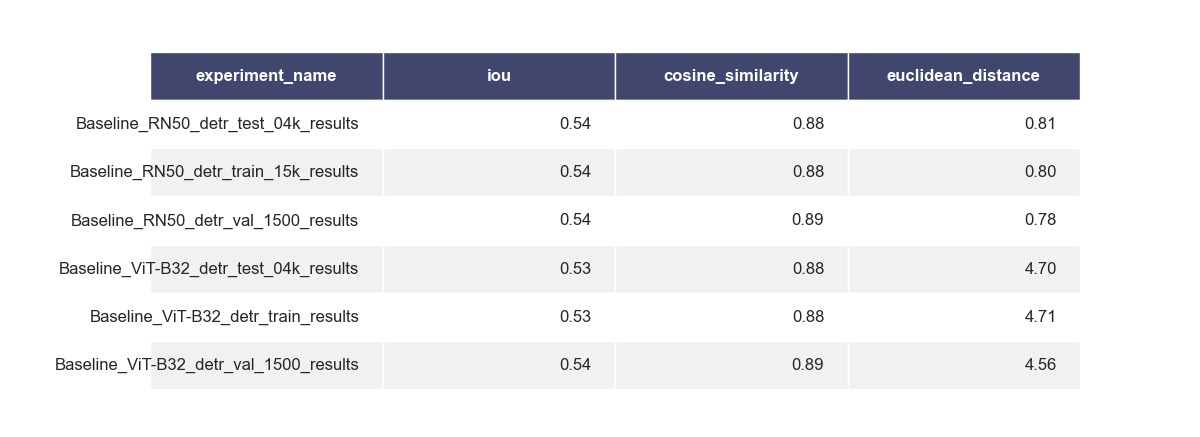



## Results on NLP + Yolov8 and Clip



*   We noticed the drop in results using this method which seems to be from the fact that extracting just the subject loses informatioon about the context of the expression. For examples if the image contains two laptops and expression is referring to one of the laptop with expression like "laptop that is turned on and is white" then our model would pick any laptop that had high similarity with the subject extracted.
*   To overcome this problem to some extent we tried to put another layer of confirmation by using NER on expression. which we couldnt test due to hours finished on the server and not having resources on colab. but additional code is added in the class that defines nlpyoloclip model clas and added as follows:
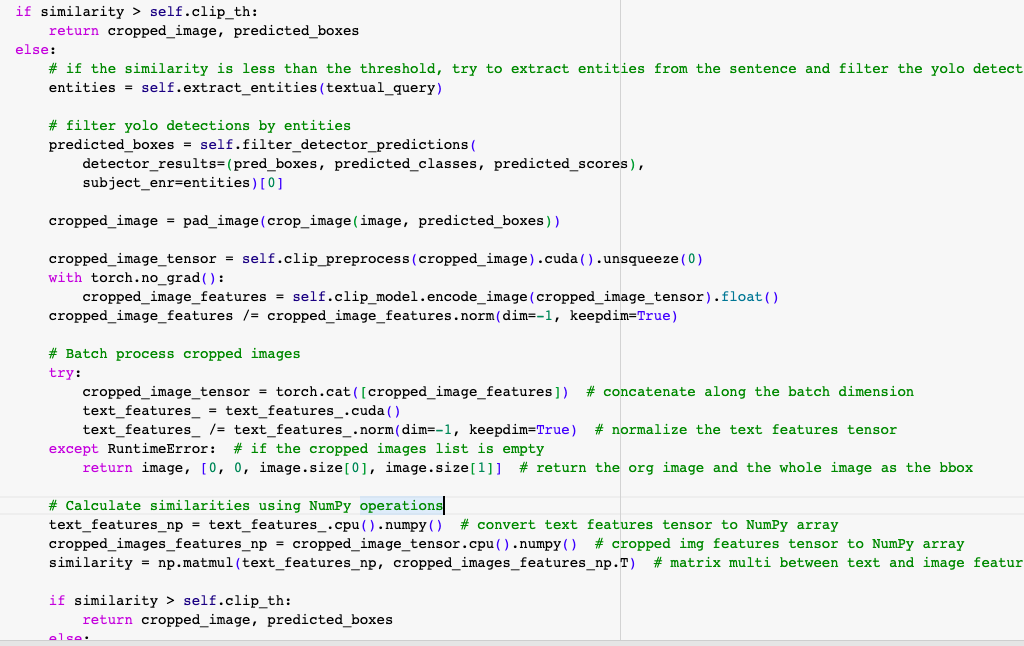

* Results without the NER model are listed below.

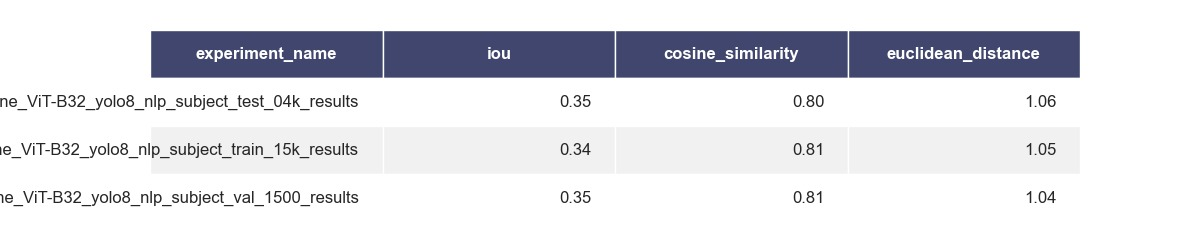




## Results with Projectionhead on Top of Clip



*   With simple projection head on were not satisfactory. we thought of integrating iou loss while training which may result in better but we couldnt test it.

    training accuracy 0.19
    Validation accuracy 0.17
    Test accuracy 0.18



# FUTURE CONSIDERATIONS

## EFFICIENT FEATURE FUSION

*   During our exploration, we encountered a paper named "TransVG." Unlike conventional methods that merely concatenate features, TransVG introduces an innovative approach. It incorporates a learnable vector to grasp the relational positions of objects within the image, referenced by the prompt, through the use of transformers. This is then followed by utilizing an MLP (Multi-Layer Perceptron) for bounding box regression.
*   Considering the rigorous training of both the Clip vision and textual encoder components, the option of substituting their pretrained transformers with those of vision and text in case of utilizing Clip for this particular task appears to hold promise for yielding favorable outcomes.

* While the code associated with the paper is accessible, we decided not to pursue this avenue due to time constraints.

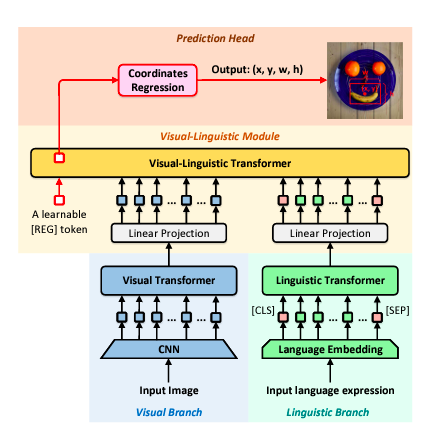



## Enhancing Visual Grounding with Pseudo-Queries and Text-to-Text Similarity

While working on idea of performing text-to-text similarity between extracted subject/entities and Yolo class labels, we found another idea which was generate pseudo-queries of cropped objects and perform text-to-text similarity with original caption. Below is detailed brain-storming concept of this idea:

In the realm of visual grounding, to enhance the performance and robustness of existing methods, we thought an innovative approach, utilizing pseudo-query generation techniques to create descriptive text for each detected object, our method aims to refine the textual-visual matching process. By calculating text-to-text similarity between these generated pseudo-queries and the original textual query, we aim to achieve more accurate and contextually relevant visual grounding results. This approach has the potential to revolutionize the way systems understand and interpret the interplay between text and visual data.

Here's a proposed pipeline that melds more brainstorming concepts with technical details to give this idea a solid foundation:

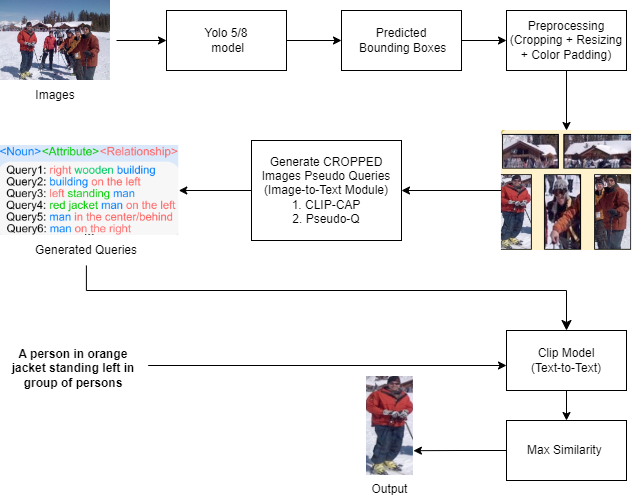

1. Deploy advanced object detectors such as YOLOv5, YOLOv8, or DETR to an image to generate bounding boxes (bboxes) for potential objects.
2. Crop the detected objects from the main image using their respective bboxes.
3. Implement padding strategies to ensure that cropped images, especially smaller objects, do not become distorted or lose content.
4. For each cropped image, generate a pseudo-query or caption that describes the object in the cropped image.
5. The method from "Pseudo-Q: Generating Pseudo Language Queries for Visual Grounding" can be used.
   * This approach focuses on generating queries that are likely to be used by users in referring expressions.
   * Alternatively, "ClipCap: CLIP Prefix for Image Captioning" can be employed. This leverages the CLIP model's capabilities to produce relevant captions for images.
6. With the generated pseudo-queries or captions at hand, calculate the similarity between each pseudo-query and the original referring expression (query) provided for the image.
   * Deploy the CLIP text model, which is designed to understand semantic content and is thus apt for this purpose.
   * Another option is to use BERT (or its variants like RoBERTa or DistilBERT) which is a transformer-based model tailored for text applications and can compute high-quality semantic embeddings.
7. Based on the calculated text-to-text similarities, select the cropped image corresponding to the pseudo-query that has the highest similarity score with the original text. This cropped image should ideally be the correct visual grounding for the original query.


Our Thoughts on this approach: By generating pseudo-queries, the system has a more informed basis to compare with the original referring expressions, thereby potentially improving the accuracy and robustness of visual grounding tasks. Integrating these methodologies could pave the way for a more intelligent and context-aware visual grounding system.

However, due to limited resources and time constraint we are not able to implement this strategy but based on research on this idea we're pretty sure that this approach may provide good results.

# References

* [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)
* [YoloV5](https://github.com/ultralytics/yolov5)
* [YoloV8](https://github.com/ultralytics/ultralytics)
* [Dynamic MDETR: A Dynamic Multimodal Transformer Decoder for Visual Grounding](https://arxiv.org/abs/2209.13959)
* [End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872)
* [MDETR -- Modulated Detection for End-to-End Multi-Modal Understanding](https://arxiv.org/abs/2104.12763)
* [CORA: Adapting CLIP for Open-Vocabulary Detection with Region Prompting and Anchor Pre-Matching](https://arxiv.org/pdf/2303.13076.pdf)
* [TransVG: End-to-End Visual Grounding with Transformers](https://arxiv.org/abs/2104.08541)
* [CLIP-VG: Self-paced Curriculum Adapting of CLIP for Visual Grounding](https://arxiv.org/abs/2305.08685)
* [Pseudo-Q: Generating Pseudo Language Queries for Visual Grounding](https://arxiv.org/pdf/2203.08481.pdf)